In [1]:
import time
import copy
from collections import defaultdict
import numpy as np
import tensorflow as tf

# Simple RL
from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

# Torch
import torch
import torch.optim as optim
from torch import FloatTensor
from torch.autograd import Variable

# https://github.com/pandas-profiling/pandas-profiling/issues/68
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# MLIRL [1]

In [2]:
def compute_policy(S, A, R, trans_dict, s_to_idx, gamma, n_iters, expl_policy, dtype, given_goal_idx=None):
    
    nS, nA = len(S), len(A)
    # Policy
    Pi = torch.ones(nS, nA, dtype=dtype) / nA
    # Value
    V = R[:,0].clone()
    # Q value
    Q = R.repeat(1,nA).clone()
    
    if given_goal_idx:
        V[given_goal_idx] = 0
    
    # Value iteration
    for _vi_iter in range(n_iters):
        for s_idx, s in enumerate(S):
            # Check if state is terminal (stop leaking values back to non-goal state space)
            if s.is_terminal() or (given_goal_idx and s_idx == given_goal_idx):
                continue
            for a_idx, a in enumerate(A):
                
                Q[s_idx, a_idx] = R[s_idx]
                for s_prime in trans_dict[s][a]:
                    Q[s_idx, a_idx] += gamma * trans_dict[s][a][s_prime] * V[s_to_idx[s_prime]].clone()
                Pi[s_idx, :] = expl_policy( Q[s_idx,:].clone())
                V[s_idx] = Pi[s_idx, :].clone().dot(Q[s_idx,:].clone())
    return Pi, V, Q

def group_by_goals(traj_states_list, traj_actions_list):
    
    goal_to_traj_idx = defaultdict(lambda: defaultdict(lambda: []))
    
    for traj_idx, traj_states in enumerate(traj_states_list):
        goal_to_traj_idx[traj_states[-1]]["traj_states_list"].append(traj_states)
        goal_to_traj_idx[traj_states[-1]]["traj_actions_list"].append(traj_actions_list[traj_idx])
    return goal_to_traj_idx

# Modified to handle given goal scenario.
def MLIRL(
        # Problem
        traj_states_list, traj_actions_list, trans_dict, phi, 
        # MLIRL
        optimizer_fn, n_iter=1, n_vi_iter=1, w_init_scheme=None,
        w_init=None, gamma=0.99, boltzmann_beta=1., loss_eps=1e-3, print_interval=1,
        goal_is_given=False, dtype=torch.float64, verbose=False):
    
    assert w_init_scheme in ["random", "zeros", "custom"]
    
    # States
    S = list(trans_dict.keys())
    s_to_idx = {s:idx for idx,s in enumerate(S)}
    n_sa_pairs = sum(len(tau_s) for tau_s in traj_states_list)
    
    # Actions
    A = list(trans_dict[S[0]].keys())
    a_to_idx = {a:idx for idx,a in enumerate(A)}
    
    # Features
    phi_S = torch.Tensor([phi(s) for s in S]).type(dtype)
    phi_dim = phi_S.shape[1]
    
    # Reward parameters
    if w_init_scheme == "custom":
        assert w_init is not None
        w = Variable(torch.Tensor(w_init).type(dtype), requires_grad=True)
    elif w_init_scheme == "zeros":
        w = Variable(torch.zeros(phi_dim, 1).type(dtype), requires_grad=True)
    elif w_init_scheme == "random" or w_init_scheme is None:
        w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
    
    # Optimization params
    optimizer = optimizer_fn([w])
    
    # Exploration policy
    expl_policy = lambda Q: (boltzmann_beta*Q).softmax(dim=0)
    
    # Book-keeping
    loss_history = []
    
    # Group by goals
    goal_to_trajectories = group_by_goals(traj_states_list, traj_actions_list)
    
    Pi, V, Q = None, None, None
    
    for _iter in range(n_iter):
        
        try:
            optimizer.zero_grad()
            loss = 0
            for goal_state, D in goal_to_trajectories.items():
                
                # Reward Estimate
                R = torch.mm(phi_S, w)  
                # Policy
                Pi, V, Q = compute_policy(S, A, R, trans_dict, s_to_idx, gamma, 
                                          n_vi_iter, expl_policy, dtype, 
                                          given_goal_idx=s_to_idx[goal_state] if goal_is_given else None)
                for traj_idx, traj_states in enumerate(D["traj_states_list"]):
                    for sample_idx, s in enumerate(traj_states[:-1]):
                        a_idx = a_to_idx[D["traj_actions_list"][traj_idx][sample_idx]]
                        loss -= torch.log(Pi[s_to_idx[s], a_idx])
                        
        # If interrupted, return current results
        except KeyboardInterrupt:
            print("Iter: {:04d} Training interrupted!".format(_iter))
            if Pi is None:
                print("No results produced..")
                raise
            return w, R, Pi, V, Q, loss_history
        
        loss.backward()
        grad_l2 = w.grad.norm(2)
        loss_norm = loss / n_sa_pairs
        
        if _iter % print_interval == 0 or _iter == n_iter-1:
            print("Iter: {:04d}, loss: {:09.6f}, "
                  "\n\t\t\t     w: [{}]"
                  "\n\t\t\t    dw: [{}]"
                  "\n\t\t\t||dw||: {:+012.7f}".format(
                      _iter, loss_norm, 
                      ' '.join("{:+012.7f}".format(v) for v in w[:,0]), 
                      ' '.join("{:+012.7f}".format(v) for v in -w.grad[:,0]), grad_l2))
            
        if loss_eps is not None and loss_norm < loss_eps:
            print("Iter: {:04d} Converged.".format(_iter))
            break
            
        optimizer.step()
        loss_history.append(loss_norm.data.tolist())
        
    return w, R, Pi, V, Q, loss_history

## Experiment Setup

In [3]:
def get_action(state, n_state):
    dx = n_state[0] - state[0]
    dy = n_state[1] - state[1]
    if dx > 0 and dy == 0: return "right"
    elif dx > 0 and dy > 0: return "up_right"
    elif dx == 0 and dy > 0: return "up"
    elif dx < 0 and dy > 0: return "up_left"
    elif dx < 0 and dy == 0: return "left"
    elif dx < 0 and dy < 0: return "down_left"
    elif dx == 0 and dy < 0: return "down"
    elif dx > 0 and dy < 0: return "down_right" 
    else: return "stay" #dx == 0 and dy == 0:
    
def get_traj_actions(tau_s):
    return [[get_action(state_traj[i], state_traj[i+1]) for i in range(len(state_traj)-1)] for state_traj in tau_s]

def get_traj_states(tau_s):
    return [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in tau_s]

def map_v_to_grid(states, V, nvmdp):
    V_grid = np.zeros((nvmdp.height, nvmdp.width))
    for i in range(len(states)):
        r, c = nvmdp._xy_to_rowcol(states[i].x, states[i].y)
        V_grid[r,c] = V[i]
    return V_grid

def compute_new_value(results):
    nvmdp_ = copy.deepcopy(results["nvmdp"])
    living_rewards_pred = np.array([nvmdp_.cell_type_feature(i) for i in nvmdp_.living_cell_ids]).dot(results["w"].data).reshape(-1,1).tolist()
    if len(nvmdp_.goal_cell_ids) == 0:
        goal_rewards_pred = []
    else:
        goal_rewards_pred = np.array([nvmdp_.cell_type_feature(i) for i in nvmdp_.goal_cell_ids]).dot(results["w"].data).reshape(-1,1).tolist()
    nvmdp_._reset_rewards(living_rewards_pred, goal_rewards_pred)
    return nvmdp_.get_value_grid()

def sample_traj_by_goals(nvmdp, goal_cell_types, goal_cell_locs, goal_cell_rewards, n_traj_per_goal=1):
    
    nvmdp_ = copy.deepcopy(nvmdp)
    traj_states_list, traj_actions_list = [], []
    for idx in range(len(goal_cell_locs)):
        nvmdp_._reset_goals([goal_cell_locs[idx]], [goal_cell_rewards[idx]], [goal_cell_types[idx]])
        a, b = nvmdp_.sample_data(n_traj_per_goal)
        traj_states_list.extend(a)
        traj_actions_list.extend(b)
    return traj_states_list, traj_actions_list

def MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=True, figsize=(10,10), print_interval=1):
    
    nvmdp = irl_problem["nvmdp"]
    traj_states, traj_actions = irl_problem["s_a_trajectories"]
    
    # Visualize Grid
    if disp_grid:
        nvmdp.visualize_grid(nvmdp.state_space, trajectories=traj_states, 
                             state_space_cmap=plt.cm.viridis, 
                             show_colorbar=True, show_rewards_colorbar=True,
                             end_marker="*k", goal_marker_sz=10)
        
    # MLIRL Inputs
    phi = lambda s: nvmdp.feature_at_state(s, "indicator", incl_cell_distances=False, incl_goal_indicator=True, incl_goal_distances=False, normalize_distance=False)
    phi_loc = lambda x,y: nvmdp.feature_at_loc(x, y, "indicator", incl_cell_distances=False, incl_goal_indicator=True, incl_goal_distances=False, normalize_distance=False)
    cell_features = np.asarray([[phi_loc(*nvmdp._rowcol_to_xy(row,col)) for col in range(nvmdp.width)] for row in range(nvmdp.height)])
    T = nvmdp.get_trans_dict()
    
    # MLIRL
    print("Training...\n\t\t\t           {}".format(' '.join("{:11}".format(v) for v in nvmdp.cell_types)))
    w, _, Pi, V, Q, loss_history,  = MLIRL(traj_states, traj_actions, T, phi, **mlirl_params, print_interval=print_interval)
    print("Done.")
    
    # Recovered Reward
    R = cell_features.dot(w.data)[:,:,0]
    
    # Display results
    if disp_results:
        display_irl_results(nvmdp, traj_states, R, V_grid, title, figsize)
    return dict(w=w, R=R, Pi=Pi, V=V, Q=Q, 
                nvmdp=nvmdp, phi=phi, phi_loc=phi_loc, 
                loss_history=loss_history)

def plot_irl(nvmdp, tau_mdp_s_list, R, loss_history=None, V=None, title="", figsize=(16,14), R_cmap=None, cell_text_size=10):
    
    plt.figure(figsize=figsize)
    plt.suptitle(title)
    
    nvmdp.visualize_grid(nvmdp.state_space, state_space_cmap=True, new_fig=False, subplot_str="221", trajectories=tau_mdp_s_list, 
                        show_colorbar=True, show_rewards_colorbar=True, end_marker="*k")
    
    plt.subplot(222)
    if loss_history is not None:
        plt.plot(np.exp(-1 * np.asarray(loss_history)))
        plt.xlabel("MLIRL iterations")
        plt.title("Log-likelihood")
        
    nvmdp.visualize_grid(R, state_space_cmap=False, cmap=R_cmap, new_fig=False, subplot_str="223",
                         show_colorbar=True, text_values=R, text_size=cell_text_size, title="Recovered R")
    if V is not None:
        nvmdp.visualize_grid(V, state_space_cmap=False, new_fig=False, subplot_str="224",
                             show_colorbar=True, text_values=V, text_size=cell_text_size, title="Recovered Value")

def plot_irl_results(results, tau_s_list, round_to=3, title="", figsize=(16,14), R_cmap=None, cell_text_size=10):
    plot_irl(nvmdp = results["nvmdp"], 
             tau_mdp_s_list = get_traj_states(tau_s_list), 
             R = results["R"].round(round_to), 
             loss_history = results["loss_history"],
             V = compute_new_value(results).round(round_to),
             title=title, figsize=figsize, R_cmap=R_cmap, cell_text_size=cell_text_size)

# Navigation MDP

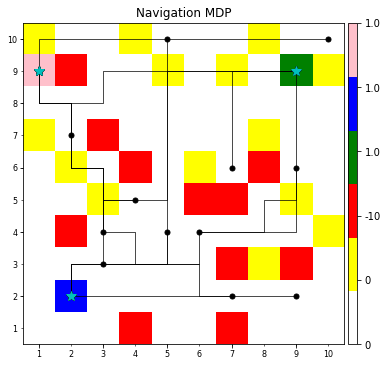

Training...
			           white       yellow      red         green       blue        pink       
Iter: 0000, loss: 01.145484, 
			     w: [-000.0159871 -000.0130280 +000.0028238 +000.0147353 -000.0097555 -000.0027577]
			    dw: [-394.5544739 -040.0093536 -251.3781128 -023.3895073 -025.6451530 -012.9310284]
			||dw||: +470.9956360
Iter: 0001, loss: 01.047133, 
			     w: [-000.1159871 -000.1130280 -000.0971762 -000.0852647 -000.1097556 -000.1027577]
			    dw: [+183.4125214 +080.5979233 -072.4378891 -027.6727943 -044.9001656 -018.4952564]
			||dw||: +220.2437439
Iter: 0002, loss: 00.951852, 
			     w: [-000.1453374 -000.0760856 -000.1821549 -000.1853561 -000.2076189 -000.2021659]
			    dw: [+211.0752258 +066.9937973 -056.0992622 -025.0145912 -040.5041504 -017.8672142]
			||dw||: +234.0375977
Iter: 0003, loss: 00.830199, 
			     w: [-000.1378277 -000.0150202 -000.2597558 -000.2852995 -000.3065603 -000.3020570]
			    dw: [+182.6117554 -026.8591366 -036.3223801 -023.2796211 -028.1933

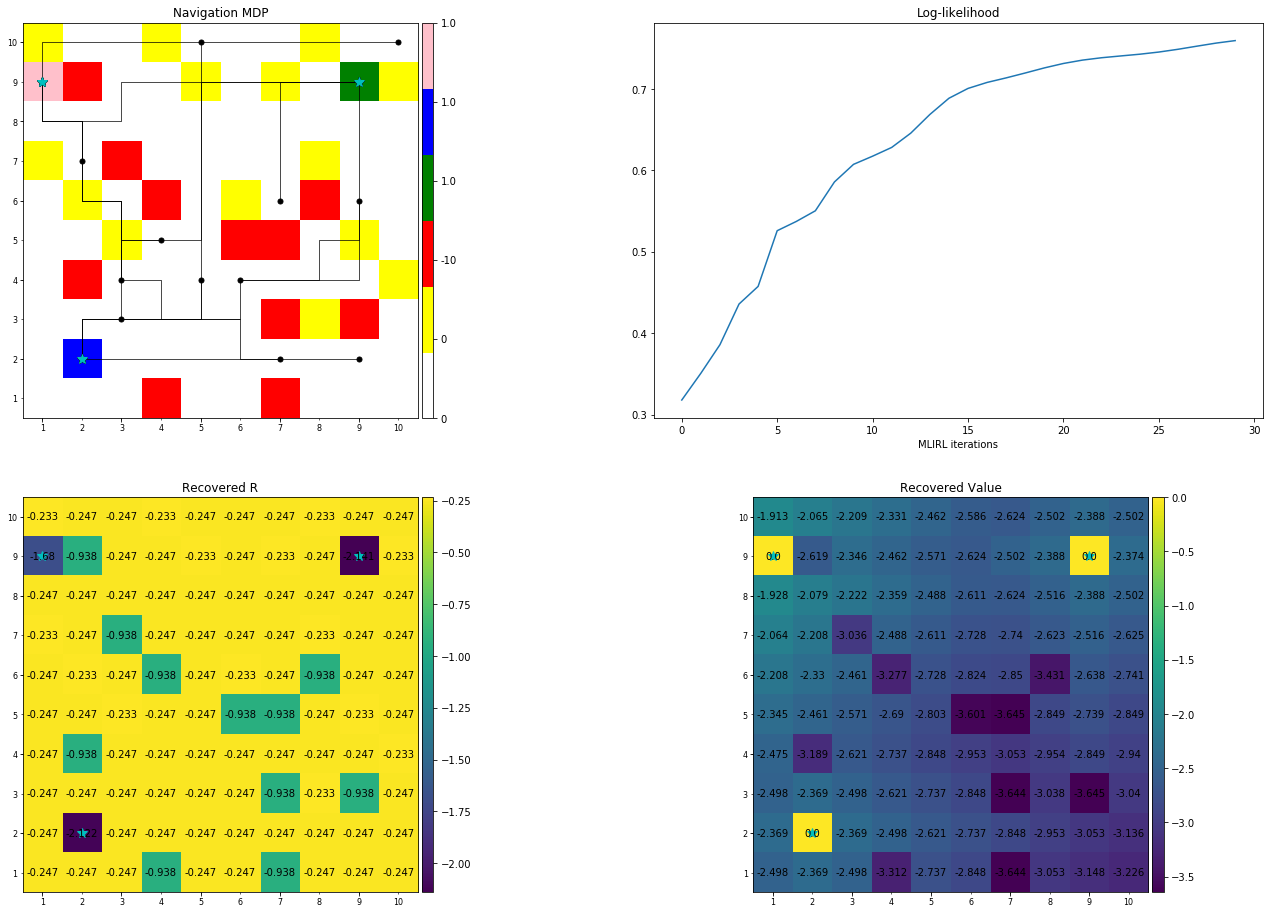

In [4]:
np.random.seed(10)
nvmdp = NavigationMDP(
    width = 10,
    height = 10,
    living_cell_distribution = "probability",
    living_cell_types = ['white', 'yellow', 'red'],
    living_cell_type_probs=[0.68, 0.17, 0.15],
    living_cell_rewards = [0, 0, -10],
    goal_cell_types = ["green", "blue","pink"],
    goal_cell_locs = [(9,9), (2,2), (1,9)],
    goal_cell_rewards = [1., 1., 1.],
    gamma = 0.95,
    name = "Navigation MDP"
    )
mlirl_params = dict(
    n_iter = 30,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 10.,
    w_init_scheme = "random",
    # w_init = results["w"].data.numpy(),
    loss_eps = -np.log(0.9), # loss = -log(likelihood), 0.9 is descent target for P(s,a)
    optimizer_fn = lambda params: optim.Adam(params, lr=0.1, weight_decay=1.),
    # optimizer_fn = lambda params: optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=1.),
    goal_is_given = True,
    )
irl_problem = dict(
    nvmdp = nvmdp,
    s_a_trajectories = sample_traj_by_goals(nvmdp, nvmdp.goal_cell_types, nvmdp.goal_locs, nvmdp.goal_cell_rewards, 4)
    )
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
plot_irl_results(results, irl_problem["s_a_trajectories"][0], figsize=(24,16))

# References

[1] Babes, Monica, et al. "Apprenticeship learning about multiple intentions." Proceedings of the 28th International Conference on Machine Learning (ICML-11). 2011.  